<a href="https://colab.research.google.com/github/MAvRK7/Neural-Nets-Learning/blob/main/BackpropPro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Back prop Ninja

Same code as last time

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [ ]:
chars= sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."]=0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)#27
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
#build dataset
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size

    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182556, 3]) torch.Size([182556])
torch.Size([22733, 3]) torch.Size([22733])
torch.Size([22857, 3]) torch.Size([22857])


In [ ]:
#boilerplate done, real stuff

In [ ]:
# our grad vs pytorch grad

# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  #checks if all dt == t.grad
  ex = torch.all(dt == t.grad).item()
  # are they approx equal?
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

X -> C -> Emb -> Embcat -> @W1+b1 ->hidden layer->hprebn -> *bngain+ bnbias -> hpract -> tanh -> h -> @W2+b2n -> Logits ->loss

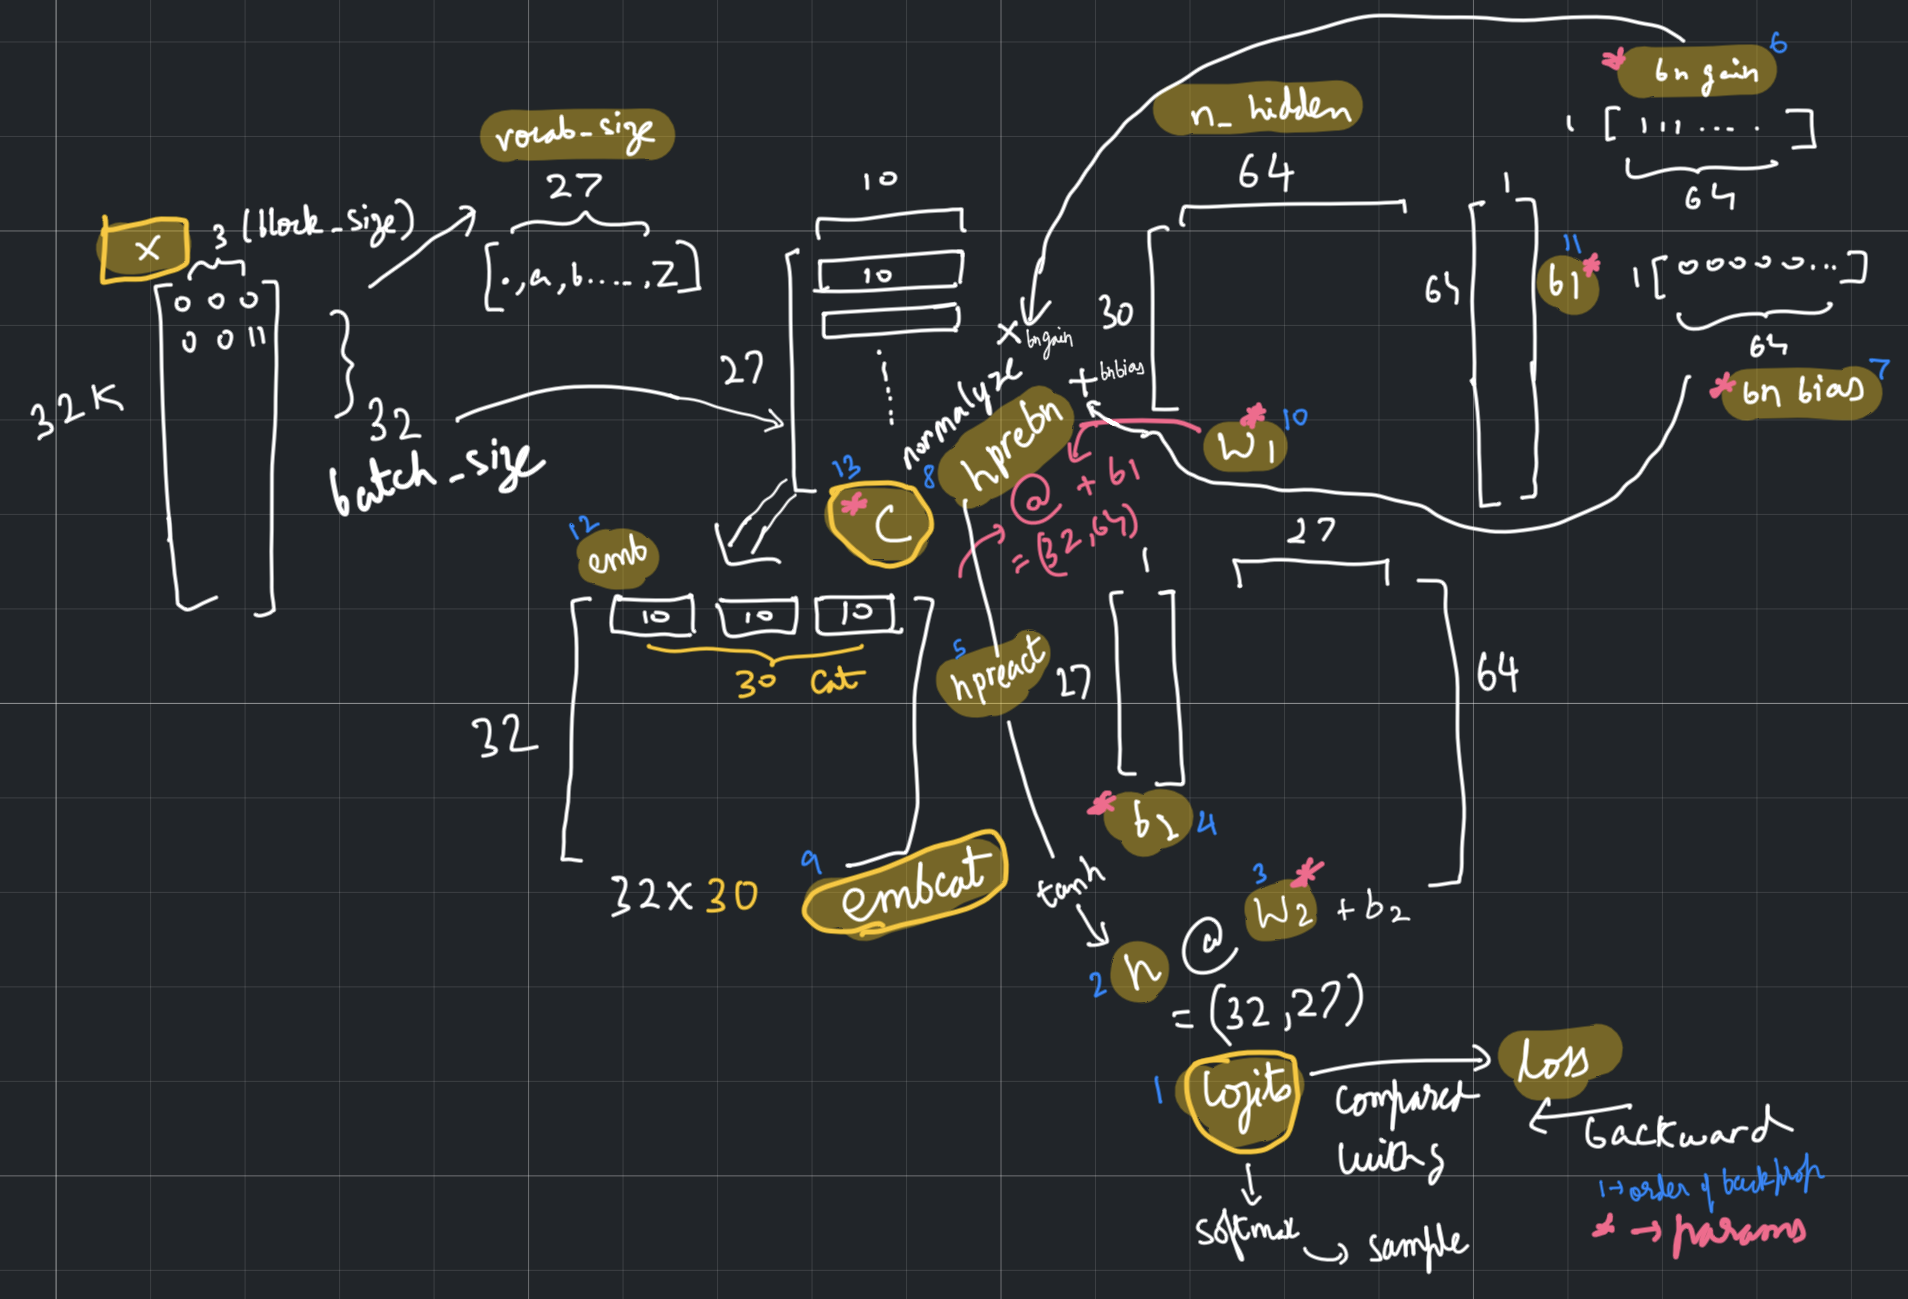

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0 #not all ones, but a little over
bnbias = torch.randn((1, n_hidden))*0.1 #not all zeros

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [ ]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [ ]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors (from 32,3,10 to 32,30)
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv #purely normalized
hpreact = bngain * bnraw + bnbias # * gain + bias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
#we got the logits
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability, +/- doesnt change probs
#we do exp and get counts
counts = norm_logits.exp() #no issue should come here, thats why we - maxes(highest no. is 0)
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
#counts/counts.sum(1, keepdims=True)
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.4637, grad_fn=<NegBackward0>)

In [ ]:
Yb

tensor([ 9,  5,  0, 12,  0,  1, 14,  1,  5, 14,  1,  5, 18,  1,  1,  1, 22, 25,
        13,  1,  6, 14, 11,  0, 15,  4,  7, 12, 12, 18, 25, 18])

In [ ]:
logprobs.shape

torch.Size([32, 27])

In [ ]:
logprobs[range(n), Yb] #there are 32, as n and Yb = 32

tensor([-3.7179, -4.2076, -3.4015, -3.3922, -2.9926, -2.8669, -2.8746, -4.3325,
        -2.6628, -3.4461, -4.2088, -2.9404, -3.4659, -3.4701, -3.9146, -3.8699,
        -2.4790, -3.6559, -3.4419, -3.2435, -3.9818, -2.9849, -3.3406, -2.9670,
        -2.8700, -4.0002, -3.1683, -3.4843, -3.7065, -4.5048, -2.9466, -4.2976],
       grad_fn=<IndexBackward0>)

So, loss will take the - of the mean of the 5th, 9th, 12th...element in logprobs (total 32 items)

so only these indices probs are cared in loss, the probs of other idices doesnt matter

In [ ]:
#back-prop through the whole thing
# d means dloss/d...
#ok, so we care about the loss,
#loss = -logprobs[range(n), Yb].mean()
#which is (the - of) the mean of all the logprobs indexed to Yb

# logprobs--[ - and mean]---> loss, dlogprobs means dloss/dlogprobs

#lets say we had 3 nos a,b,c
# loss = - (a+b+c)/3
# loss = -1/3 a + -1/3 b + -1/3 c
# dloss/da = -1/n (not 3, since we have 32)

dlogprobs = torch.zeros_like(logprobs) #or torch.zeros((32,27)) coz the d of smthg will always be of the same shape, only those having
#the right indices will have a grad, everything else will be a 0
dlogprobs[range(n), Yb] = -1.0/n #its 1/n because its carried through
dlogprobs.shape #only those indices have value, everything else is 0

# OR dlogprobs = F.one_hot(Yb, num_classes=logprobs.shape[1]) * (-1.0 / n)

torch.Size([32, 27])

In [ ]:
#comparing ours vs pytorch's
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


In [ ]:
#next, we have logprobs = probs.log(), so to all elemns of probs, if we do log, we get logprobs
# probs -->[log]---> logprobs
#so dprobs= dif of log * dlogprobs
# wkt d/dx (log x) = 1/x, here x is probs
dprobs = (1.0/probs) * dlogprobs

#check
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


In [ ]:
#probs = counts * counts_sum_inv
#next is counts_sum_inv;  1/counts_sum = counts_sum_inv
# dloss/dprobs * dprobs/ dcounts_sum_inv = dloss/dcounts_sum_inv => dcounts_sum_inv = dprobs * d(counts * counts_sum_inv)/d counts_sum_inv
# but counts.shape is 32,27 and counts_sum_inv.shape is 32,1
# as probs = counts * counts_sum_inv, first counts_sum_in gets copied 27 times

#toy eg
# c = a @ b, a = [3,3] and b = [3,1]
# pytorch does broadcasting
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 b32*b2
# a31*b3 a32*b3 a33*b3

#op 1: replication, op2: multiplication
# local der of dc/db in c=a*b is a, so here, d probs/ d counts_sum_inv = counts
# global der is dprobs
# now, if the same var is used multiple times, its summed, eg b1 is used mult times

# "if a node is used mutiple times, its gradients for all of its uses, sum during back-prop"

dcounts_sum_inv = (counts * dprobs).sum(1,keepdim=True) #chain rule and sum
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
#next we have counts, similarly
#dcounts = dprobs * d(counts * counts_sum_inv)/dcounts = dprobs * counts_sum_inv
dcounts = counts_sum_inv * dprobs #broadcasting happens [32,27] [32,1], no sum coz counts does not get broadcasted

#next counts_sum_inv = counts_sum**-1,
# d counts_sum = dcounts_sum_inv * dx^-1/dx ->where x is count_sum; dx^-1/x is -1/x^2
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv #same shape
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


Do the "hop" (chain rule), then check shape

If shape is the same, no sum, just chain rule

In [ ]:
(-counts_sum**-2).shape, counts_sum_inv.shape, counts_sum.shape

(torch.Size([32, 1]), torch.Size([32, 1]), torch.Size([32, 1]))

In [ ]:
#next counts_sum = counts.sum(1, keepdims=True), we want dcounts again
#imagine
#1 2 3 -> b1 which is (1+2+3)
#4 5 6 -> b2 (4+5+6)
#7 8 9 -> b3 (7+8+9)
# we have dcounts_sum -> + (plus) routes or distributes gradient, the grad of 1,2,3 is b1...4,5,6 is b2...7,8,9 is b3
# so dcounts is just dcounts_sum broadcasted into the shape of counts
print(counts.shape, counts_sum.shape)

dcounts += torch.ones_like(counts) * dcounts_sum #+= coz we have counts before also
cmp('counts', dcounts, counts)

torch.Size([32, 27]) torch.Size([32, 1])
counts          | exact: True  | approximate: True  | maxdiff: 0.0


So the gradient from dcounts_sum got distributed (row wise) to dcounts

* When shapes dont match in fwd, sum happens in backward (along the dim that didnt match)

Shapes dont match means Everything on the right is != everything on the left eg [1,64] = [32,64] * [32,64] , sum[0] happens

for [32,64] = [32,64] * [1,64] sum DOES NOT happen

* When sum happens in fwd, gradients gets dist (along the dim the sum happened)

In [ ]:
#next counts = norm_logits.exp()
# dnorm_logits = dcounts * norm_logits.exp() Coz diff of e^x is e^x
# now, norm_logits.exp() is counts, so
dnorm_logits = dcounts * counts
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


In [ ]:
#next norm_logits = logits - logit_maxes
#but check shapes
print(norm_logits.shape, logits.shape, logit_maxes.shape)

#this is like
# c    =    a    -  b ; where c is norm_logits, a is logits, b is logit_maxes
#1 2 3    1 2 3     1
#4 5 6 =  4 5 6  -  2
#7 8 9    7 8 9     3

#so 8 = 8-3
#derivatives on c will flow as is to a, but - to b, but b is broadcasted, so we must also sum

torch.Size([32, 27]) torch.Size([32, 27]) torch.Size([32, 1])


In [ ]:
#flow as is to a
dlogits = dnorm_logits.clone()
# flow with - to b and sum the duplicates
dlogit_maxes = (-dnorm_logits).sum(1, keepdims=True)
#logits are used again above, so we will come back
#check logit_maxes
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


In [ ]:
#now, the only reason why we had logit_maxes is to not overflow when we do exp
#so theres no "learning", so the gradient should be 0
dlogit_maxes
#very small numbers

tensor([[ 1.1642e-09],
        [ 3.7253e-09],
        [-1.3970e-09],
        [-4.6566e-10],
        [-1.8626e-09],
        [-1.8626e-09],
        [-1.8626e-09],
        [-6.2864e-09],
        [-5.5879e-09],
        [ 2.3283e-09],
        [ 3.7253e-09],
        [ 9.3132e-10],
        [ 5.5879e-09],
        [-1.3970e-09],
        [-2.7940e-09],
        [-4.6566e-10],
        [-1.6298e-09],
        [ 4.6566e-09],
        [-4.4238e-09],
        [-1.3970e-09],
        [-1.3970e-09],
        [ 9.3132e-10],
        [-6.2864e-09],
        [ 0.0000e+00],
        [-3.7253e-09],
        [ 6.9849e-09],
        [-3.7253e-09],
        [-8.1491e-09],
        [ 0.0000e+00],
        [ 2.3283e-09],
        [ 5.8208e-09],
        [ 4.6566e-10]], grad_fn=<SumBackward1>)

torch.Size([32, 27])
logits          | exact: True  | approximate: True  | maxdiff: 0.0


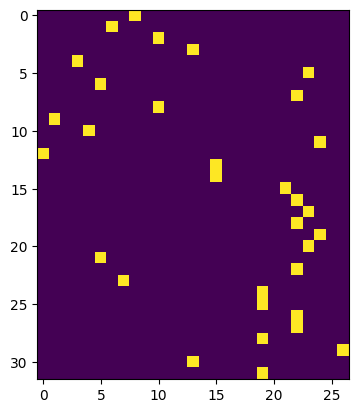

In [ ]:
#next logit_maxes = logits.max(1, keepdim=True).values
# since its just a num, the local gradient is 1
# so the gradient from logit_maxes will flow to only the indices in logits with max (after * 1)
# logits is [32,27], logits[1] = 27
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))
print(logits.shape)

#so take only those maxes and * with dlogit_maxes
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
# 1. logits.max(1).indices picks the max from the row along 1
# 2. F.one_hot(..., num_classes=...) converts that into 1 hot (1 in those indices, 0 everywhere else)
# 3. * dlogit_maxes puts those maxes in the place of the 1s

#this is another way, apart from the zoros and then populate way
#check
cmp('logits', dlogits, logits)

In [ ]:
#next logits = h @ W2 + b2
print(dlogits.shape, h.shape, W2.shape, b2.shape)

torch.Size([32, 27]) torch.Size([32, 64]) torch.Size([64, 27]) torch.Size([27])


In [ ]:
# how to diff matrix mult? make the dims work
# we want dh, shape of dh should be same as h ie [32,64]
# the only way to get that is dlogits @ (W2)T transpose
dh = dlogits @ W2.T
#similarly dW2 - same shape as W2 ie (64,27) - h transpose @ dlogits
dW2 = h.T @ dlogits
#then db2 is of shape [27], so we take dlogits - shape [32,27] and remove the 0th to make it just [27]
db2 = dlogits.sum(0)

#check
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)

h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0


In [ ]:
#next h = torch.tanh(hpreact)
# wkt if a = tanh(z)
# da/dz = 1- a^2
#dhpreact is dloss/dhpreact or dh/dhpreact * dloss/dh or dh
dhpreact = (1.0 - h**2) * dh
#check
cmp('dhpreact', dhpreact, hpreact)

hpreact         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [ ]:
#next hpreact = bngain * bnraw + bnbias
print(f"{hpreact.shape=}, {bngain.shape=}, {bnraw.shape=}\n{bnbias.shape=}")
#bngain, bnbias same shape [1,64] ; hpreact and bnraw same shape [32,64]
#we want dbngain, as its a *, the grad flips
# now bnraw * dhpreact is [32,64] and bngain is [1,64]
# so in hpreact = bngain * bnraw + bnbias, bngain gets replicated vertically 64 times
#bascially whetever is dif will get replicated
# so we need to sum it
dbngain = (bnraw * dhpreact).sum(0, keepdim= True)

#next, bnraw
#bnraw is of shape [32,64] and bngain * dhpreact is of shape [32,64] coz of hpreact, so no worries
dbnraw = bngain * dhpreact

#then bnbias, dbnbias is of shape [1,64] and dhpreact is [32,64]
# so in the op, dbnbias gets replicated vertically 32 times
dbnbias = (dhpreact).sum(0, keepdim=True)

#check
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)

hpreact.shape=torch.Size([32, 64]), bngain.shape=torch.Size([1, 64]), bnraw.shape=torch.Size([32, 64])
bnbias.shape=torch.Size([1, 64])
bngain          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnbias          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnraw           | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [ ]:
#next bnraw = bndiff * bnvar_inv
# we want dbndiff
print(f"{dbnraw.shape=}, {bndiff.shape=}, {bnvar_inv.shape=}")
# no sum because altho bnvar_inv is [1,64], dbnraw will fix it to [32,64]
# check FULL shape
dbndiff = bnvar_inv * dbnraw
# next dbnvar_inv
# (bndiff * dbnraw).shape is [32,64] , but dbnvar_inv is [1,64], so in the op it gets dist
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)

#check
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
# 'bnvar' is used later

dbnraw.shape=torch.Size([32, 64]), bndiff.shape=torch.Size([32, 64]), bnvar_inv.shape=torch.Size([1, 64])
bnvar_inv       | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [ ]:
#next bnvar_inv = (bnvar + 1e-5)**-0.5 = 1/ sqrt(bnvar + e)
# we need dbnvar (power rule) d x^n/dx = n x^n-1
dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv

#check
cmp('bnvar', dbnvar, bnvar)

bnvar           | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


In [ ]:
#basically use Bessel's correction (n-1) where lots of small numbers are there when calculating Var
# next is bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
print(f"{bnvar.shape=} {bndiff2.shape=}")
#basically whenever sum is in fwd pass, we'll have replication/broadcasting in backward
#when we have broadcating/rep in fwd pass, we'll have sum (re-use)

# in this exp, we are scaling a matrix by a scalar and then summing vertically
# a11 a12  ----> [b1,b2]
# a12 a22
#where b1 = 1/(n-1) * (a11+a21)
# b2 = 1/(n-1) * (a12+a22)

dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar

cmp('bndiff2', dbndiff2, bndiff2)

bnvar.shape=torch.Size([1, 64]) bndiff2.shape=torch.Size([32, 64])
bndiff2         | exact: False | approximate: True  | maxdiff: 1.4551915228366852e-11


In [ ]:
# next bndiff2 = bndiff**2; chain rule
dbndiff += (2 * bndiff) * dbndiff2 #same shape, its there before so +=

cmp('bndiff', dbndiff, bndiff)

bndiff          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-10


In [ ]:
#next bndiff = hprebn - bnmeani
# hprebn.shape, bndiff.shape #same shape
dhprebn = dbndiff.clone()

cmp('hprebn', dhprebn, hprebn)

# bnmeani.shape, bndiff.shape #diff shape [1,64] and [32,64]
# dbnmeani = (torch.ones_like(bndiff) * -bndiff).sum(0) or
dbnmeani = (-bndiff).sum(0)

cmp('bnmeani', dbnmeani, bnmeani)

hprebn          | exact: False | approximate: False | maxdiff: 0.001203501014970243
bnmeani         | exact: False | approximate: False | maxdiff: 0.03851202875375748


In [ ]:
# next bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# sum is there in fwd so distribution of grad
dhprebn += (1.0/n)*(torch.ones_like(hprebn) * bnmeani)

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: False | maxdiff: 0.051697809249162674


In [ ]:
# next hprebn = embcat @ W1 + b1
print(f"{hprebn.shape=}, {embcat.shape=}, {W1.shape=},\n{b1.shape=}")

#we want dembcat, which is same shape as embcat [32,30]
dembcat = dhprebn @ W1.T
# dW1 is [30,64],
dW1 = dembcat.T @ dhprebn
#b1 is [64]
db1 = dhprebn.sum(0)

# check
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)

hprebn.shape=torch.Size([32, 64]), embcat.shape=torch.Size([32, 30]), W1.shape=torch.Size([30, 64]),
b1.shape=torch.Size([64])
embcat          | exact: False | approximate: False | maxdiff: 0.217165008187294
W1              | exact: False | approximate: False | maxdiff: 0.36542266607284546
b1              | exact: False | approximate: False | maxdiff: 1.654329776763916


In [ ]:
#next embcat = emb.view(emb.shape[0], -1)
print(f"{embcat.shape=},{emb.shape=}")

#we viewed emb as 32,30, we need to view it as it was originally now
demb = dembcat.view(emb.shape)

cmp('emb', demb, emb)

embcat.shape=torch.Size([32, 30]),emb.shape=torch.Size([32, 3, 10])
emb             | exact: False | approximate: False | maxdiff: 0.217165008187294


In [ ]:
#finally, emb = C[Xb]
print(f"{emb.shape=},{C.shape=},{Xb.shape=}")
print(Xb[:5])
# in emb [32,3,10], we have 32 egs, 3 chars, each has a 10 dim embedding
# which was done using lookup table C which has 27 possible chars, each of them 10 dim
# we looked up at the rows specified by Xb. [32,3]
# here, the 9th, 25th and 1st comes into the nn, and we want to predict what comes after 9,25,1
# each of these ints - which row we want to pluck out from C, and we arrange that in 32,3,10
# we need to route the gradients back from C
# so which row of C, did every one of these 10 dim embs come from? -> we put into dC
#we need to undo these embeddings and transfer grad from emb to C and Xb
# if used multiple times (eg 0,0), we sum

dC = torch.zeros_like(C) #27,10
for i in range(Xb.shape[0]):
  for j in range(Xb.shape[1]): #iterate over all elements in Xb
    dC[Xb[i,j]] += demb[i,j] # + because the same row may be used again

cmp('C', dC, C)


emb.shape=torch.Size([32, 3, 10]),C.shape=torch.Size([27, 10]),Xb.shape=torch.Size([32, 3])
tensor([[ 0,  0, 25],
        [ 0,  0, 12],
        [20,  5, 18],
        [ 0, 13, 15],
        [25,  1,  8]])
C               | exact: False | approximate: False | maxdiff: 4.436108112335205


The below img shows arrows in fwd

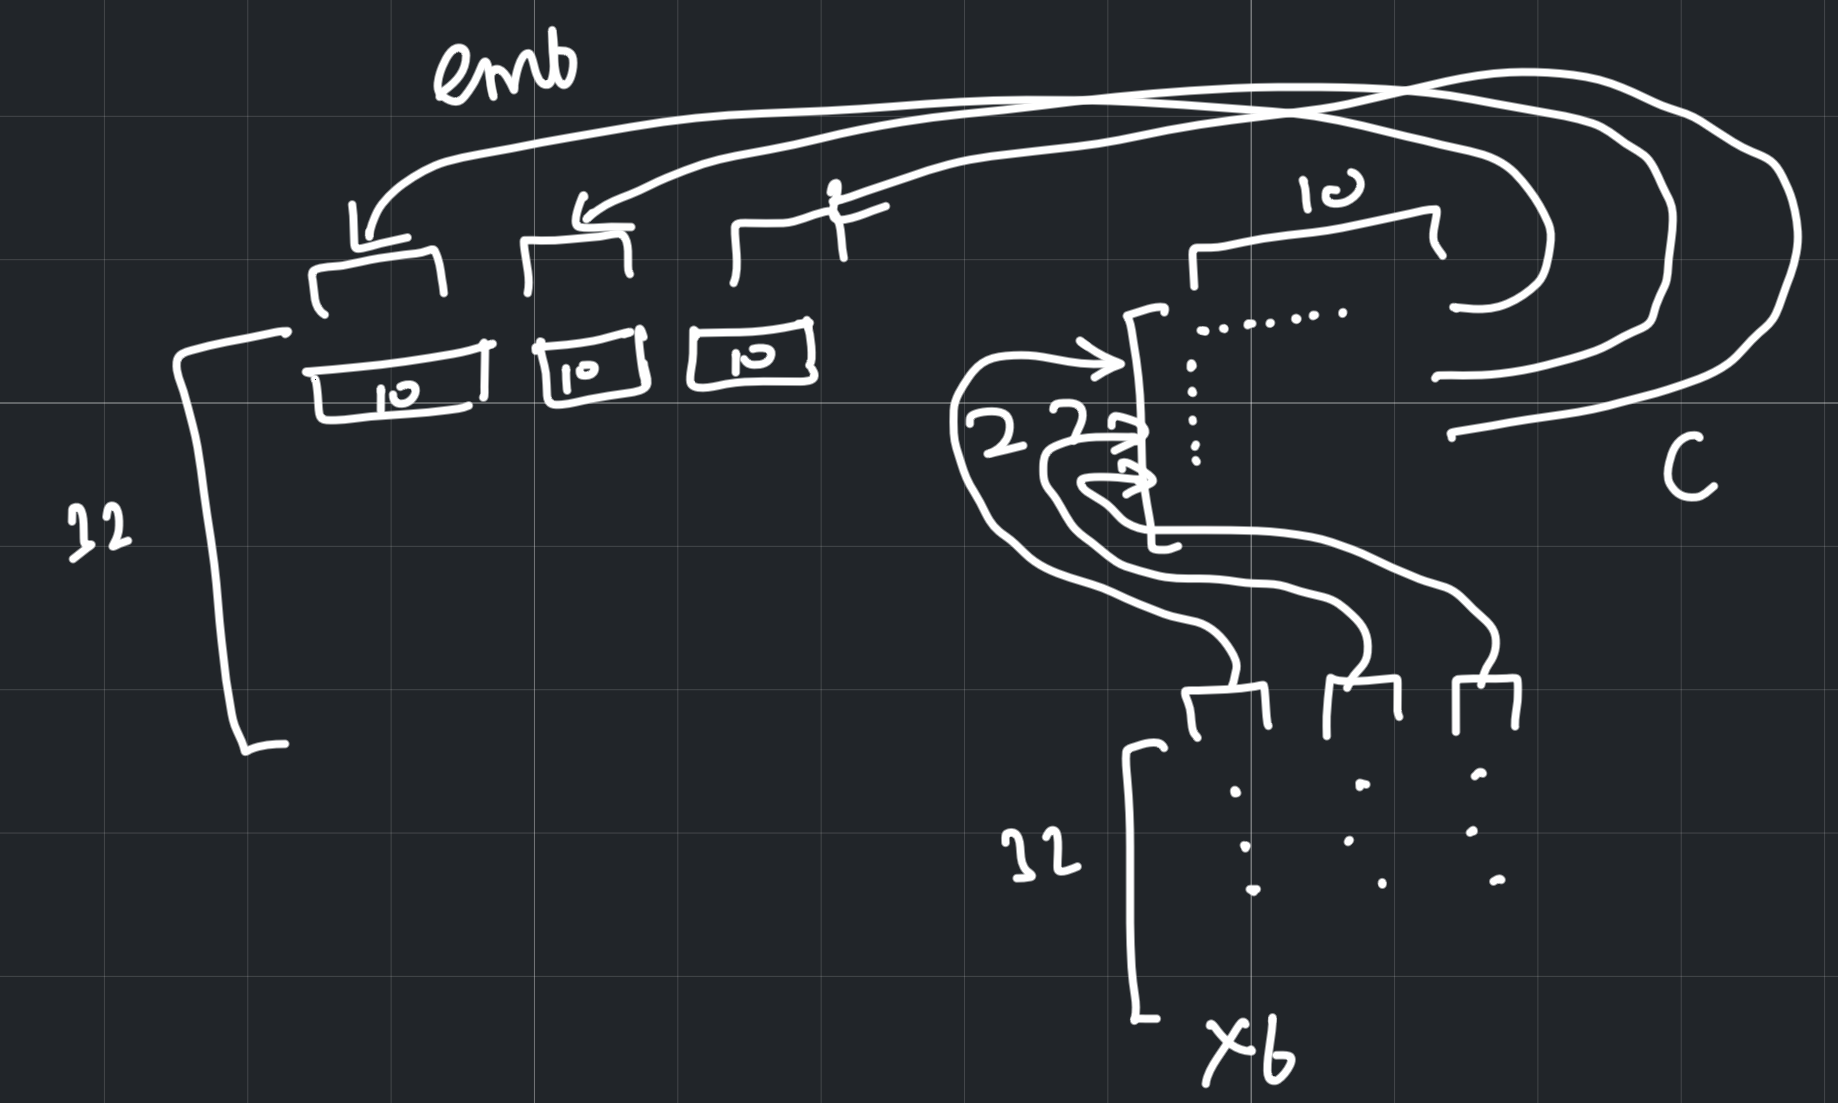

Second part

We used a simplified loss function

In [ ]:
# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.4636669158935547 diff: 2.384185791015625e-07


In [ ]:
logits.shape #32 batch size, 27 possible chars, to get highest prob per char we do softmax along 1

torch.Size([32, 27])

Now that the forward is charged (much faster) the backward is also faster (one line), we want dlogits as a func of logits and Yb

We want dloss/dlogits (aka dlogits)

SLOW:

X + W -> [Logits] -softmax-> [Probs] j rows -> Prob[j] - -log -> -logprobs[j] -> loss

FAST back prop:

Direct from loss to logits

loss = -log Py -> eq 1

WKT softmax prob, Pi = e^li / ∑j (e^lj)

Put in eq 1, loss = -log( e^li / ∑j (e^lj) )

We want dlogits or dloss/ dlogits = d/dli ( -log( e^li / ∑j (e^lj) ) )

* Logits: raw scores li for each class
* Softmax: converts logits to probs Pi = e^li / ∑j (e^lj)
* Loss: for true class y, loss = -logPy

Gradient: dloss/dli (aka dlogits) tells us how to nudge each li during backprop

1. Case 1
When 𝑖 =𝑦 (i.e. the logit corresponds to the true label),

 dlogits = Pi - 1

why -1? if we do p-1, the gradient becomes -ve, we go the opp. way of gradient to dec loss

2. Case 2 When 𝑖 ≠ 𝑦 (i.e. the logit is for a wrong class)

dlogits = Pi

Why? These classes are getting too much probability. We want to reduce their logits, so we push them down by their current probability. (we DONT push everyone down by the same)

So, in either case, we need the softmax prob Pi

But total push up = total push down

In [ ]:
#backward
# we want dlogits
# from the math, where i=label (correct), we do p=p-1, where its not label, p=p

dlogits = F.softmax(logits, 1) #along --
dlogits[range(n), Yb] -=1 #This selects the prob of the correct class for each batch item among 32 and does -1
#we also need to backprop through that div of average (/n), for all batches, we take the avg loss
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


In [ ]:
F.softmax(logits,1)[0]

tensor([0.0419, 0.0227, 0.0351, 0.0301, 0.0558, 0.0377, 0.0277, 0.0318, 0.0751,
        0.0243, 0.0373, 0.0403, 0.0305, 0.0518, 0.0574, 0.0708, 0.0329, 0.0263,
        0.0269, 0.0236, 0.0290, 0.0180, 0.0395, 0.0183, 0.0272, 0.0495, 0.0384],
       grad_fn=<SelectBackward0>)

In [ ]:
dlogits[0] * n #everything is same as above, except correct ones have a -1

tensor([ 0.0419,  0.0227,  0.0351,  0.0301,  0.0558,  0.0377,  0.0277,  0.0318,
         0.0751, -0.9757,  0.0373,  0.0403,  0.0305,  0.0518,  0.0574,  0.0708,
         0.0329,  0.0263,  0.0269,  0.0236,  0.0290,  0.0180,  0.0395,  0.0183,
         0.0272,  0.0495,  0.0384], grad_fn=<MulBackward0>)

the sum of probs out of softmax must be 1 and the gradients out of softmax must sum up to 0

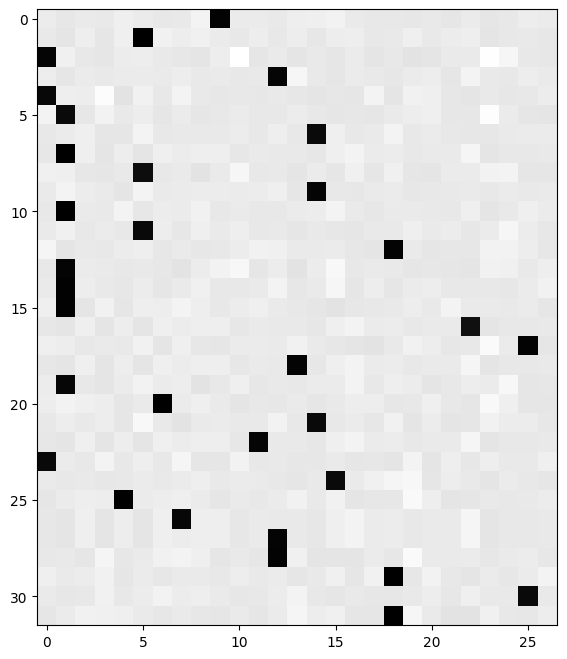

In [ ]:
#more info about dlogits
# 32 egs by 27 chars
# dlogits is the probs matrix in the fwd pass
#black- positions of correct indices

plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(),cmap='grey')

In [ ]:
dlogits[0].sum() #its basically 0

tensor(2.5611e-09, grad_fn=<SumBackward0>)

Analogy

The amount which the correctly predicted parts are "pulled up" is equal to the parts which the incorrect parts are "pulled down"

if something is confidenly wrong it goes down by x, if another thing is cofidenly correct, it goes by up the same x

Third part

We now do the same for batchnorm as we did for crossentropy loss in 2

In [ ]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass, we have hprebn and we get hpreact

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now: FAST fwd pass
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [ ]:
#steps in batch norm
# 1. Mean Mu = 1/n * (∑ xi)

# 2. Variance = 𝜎^2 = ∑ (xi - mu) / n-1      [n-1 is bessel's]

# 3. xi hat -> normalized (- mean and / by SD) xi- mean / sd + e

# 4. yi = bngain * xi hat + bnbias

# in the backward, we have dhpreact (dL/dyi) and we want dhprebn (dL/dxi)

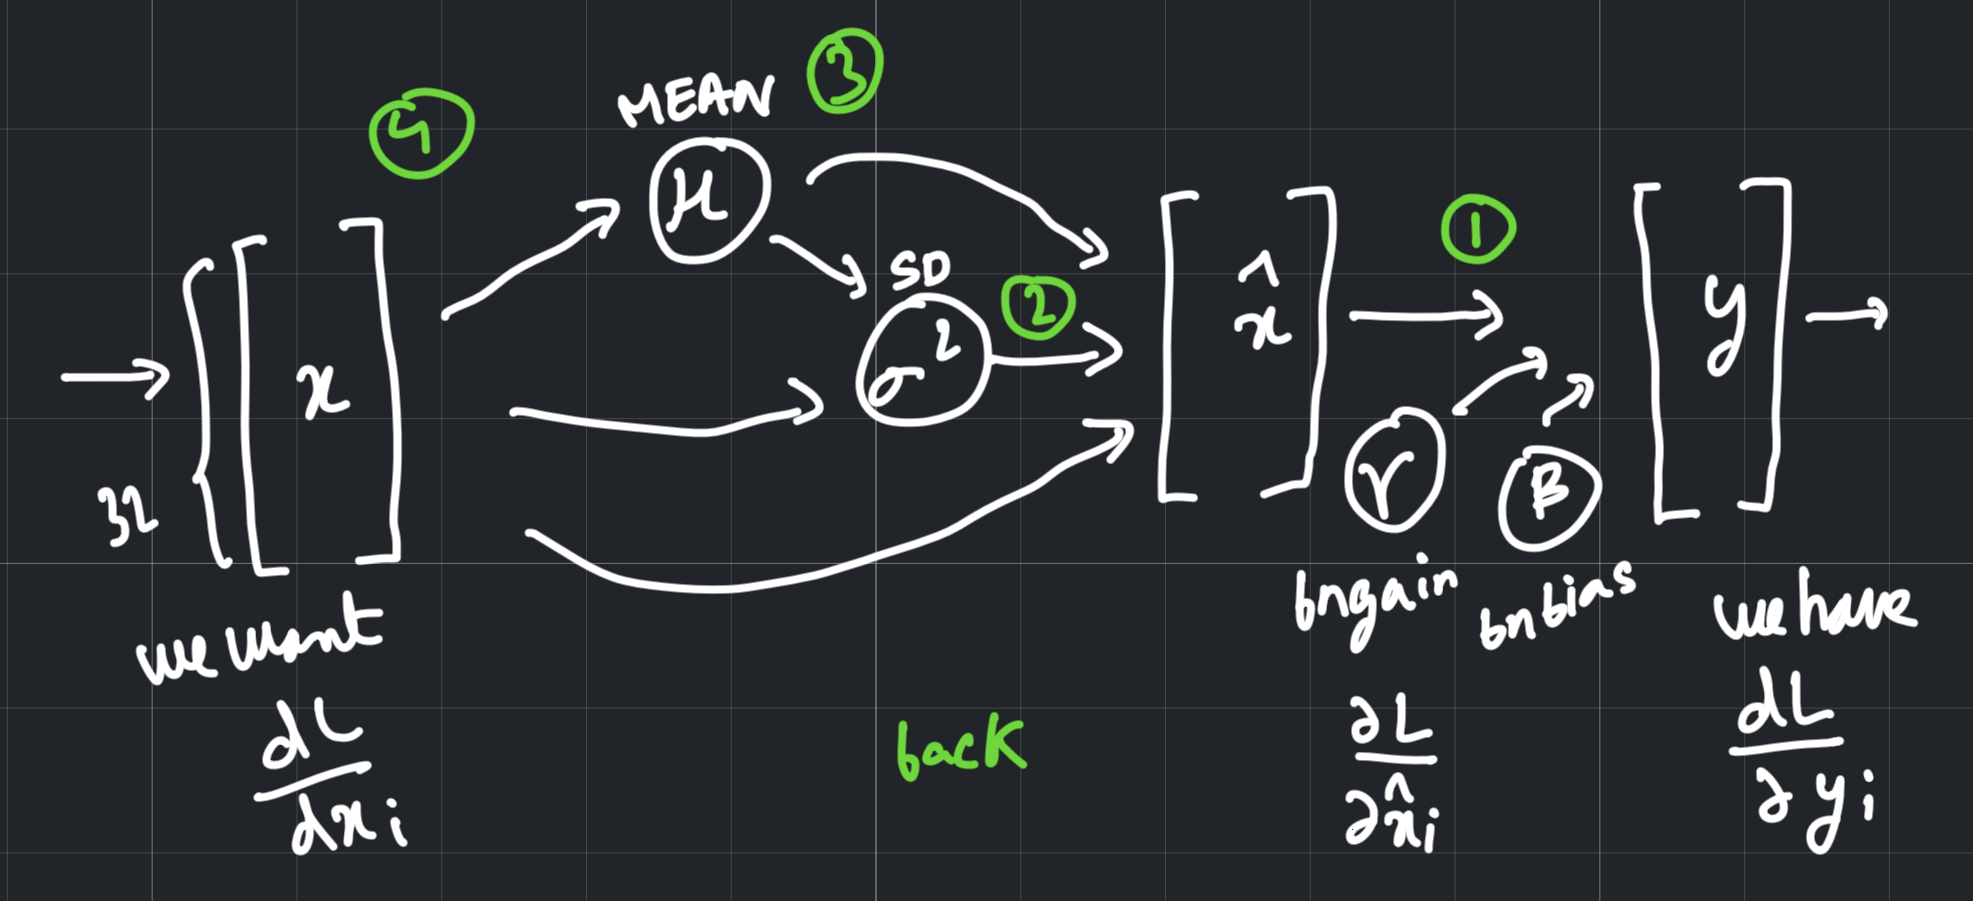

1. coz of

yi = bngain * xhat i + bnbias

dL/ d xhat i = dL/dyi * dyi/dxi hat

dyi/dxhat i = bngain

dL/ d xhat i = dL/dyi * bngain ; we have dxhat i

This gives us the [1] dxhati for each i, using this we can find [2] dL/d
𝜎 ^2  -> then [3] dL/d mu and then ->[4] dL/dxi

2. dL/ 𝜎 ^2: ∑ (dL/dxhat i * dxhat i/d 𝜎 ^2) ∑ because each xi hat uses 𝜎 ^2 ; we have d𝜎 ^2
3. dL/ d mu = ( ∑(dL/dxhat i * dxhat i/ dmu) + (dL/d𝜎 ^2 * d𝜎 ^2/dmu))
4. dL/dxi = ( (dL/dxhat i) * (dxhat i/dxi) ) + ( (dL/ dmu) * (dmu/dxi) ) + ( (dL/d𝜎 ^2) + (d𝜎 ^2/dxi) )

we havent got (dxhat i/dxi), (dmu/dxi) and (d𝜎 ^2/dxi) yet, we need to get this, but once we have it, we can do it


In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0)-n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


Exercise 4

All together

In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  # YOUR CODE HERE :)
  dlogits = F.softmax(logits, 1)
  dlogits[range(n), Yb] -=1
  dlogits /= n
  # 2nd layer backprop
  dh = dlogits @ W2.T
  dW2 = h.T @ dlogits
  db2 = dlogits.sum(0)
  #tanh
  dhpreact = (1.0-h**2) * dh
  #batch norm backprop
  dbngain = (bnraw * dhpreact).sum(0, keepdim= True)
  dbnbias = (dhpreact).sum(0, keepdim=True)
  dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
  # 1st Layer
  dembcat = dhprebn @ W1.T
  dW1 = embcat.T @ dhprebn
  db1 = dhprebn.sum(0)
  # embedding
  demb = dembcat.view(emb.shape)
  dC = torch.zeros_like(C)
  for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
      ix = Xb[k,j]
      dC[ix] += demb[k,j]
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    #p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    break

12297
      0/ 200000: 3.6874


In [ ]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.6065314412117004e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 9.313225746154785e-09
(200,)          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 4.470348358154297e-08
(27,)           | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


Running full

In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    # loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    # YOUR CODE HERE :)
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -=1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    #tanh
    dhpreact = (1.0-h**2) * dh
    #batch norm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim= True)
    dbnbias = (dhpreact).sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st Layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #  break

12297
      0/ 200000: 3.6581
  10000/ 200000: 2.1856
  20000/ 200000: 2.1637
  30000/ 200000: 1.8002
  40000/ 200000: 2.2953
  50000/ 200000: 2.1851
  60000/ 200000: 1.8487
  70000/ 200000: 2.1592
  80000/ 200000: 2.3774
  90000/ 200000: 1.6819
 100000/ 200000: 2.3378
 110000/ 200000: 2.2797
 120000/ 200000: 2.1105
 130000/ 200000: 2.1867
 140000/ 200000: 2.0972
 150000/ 200000: 2.3752
 160000/ 200000: 2.2569
 170000/ 200000: 2.1368
 180000/ 200000: 1.9620
 190000/ 200000: 2.1508


In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066959857940674
val 2.113706111907959


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carlah.
amille.
khi.
mili.
thiyah.
cassie.
mahnen.
delynn.
jarqui.
nellara.
chaihvik.
leigh.
ham.
join.
quint.
sulio.
alianni.
waterri.
jarynix.
kaelis.
